# Skin Cancer Classification for Detecting Melanoma

## 1. Preprocessing

### 1.1. Data preprocessing

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import os
from sklearn.datasets import load_files
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Load text files with categories as subfolder names.
path = "./Dataset/Image dataset/"
data = load_files(path)

In [3]:
print("Filename: \n", data['filenames'][:5])
print("Targets: \n", data['target'][:5])

Filename: 
 ['./Dataset/Image dataset/others/ISIC_0025232.jpg'
 './Dataset/Image dataset/others/ISIC_0000822.jpg'
 './Dataset/Image dataset/melanoma/ISIC_0010417_270_angle_flipped.jpg'
 './Dataset/Image dataset/others/ISIC_0027660.jpg'
 './Dataset/Image dataset/melanoma/ISIC_0010912_180_angle.jpg']
Targets: 
 [1 1 0 1 0]


In [4]:
# Getting the labels
target = np_utils.to_categorical(np.array(data['target']), 2)
target

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [5]:
len(data['filenames']) * 0.95

30229.949999999997

In [6]:
# Splitting the data into the training and validation set
train_files, train_targets = data['filenames'][:30229], target[:30229]
valid_files, valid_targets = data['filenames'][30229:], target[30229:]

### 1.2. Image preprocessing

In [7]:
# Importing the libraries
import keras
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

In [8]:
def path_to_tensor(img_path):
    """
    Getting a tensor from a given path.
    """
    # Loading the image
    img = image.load_img(img_path, target_size=(512, 512))
    # Converting the image to numpy array
    x = image.img_to_array(img)   
    # convert 3D tensor to 4D tensor with shape (1, 512, 512, 3)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """
    # Getting a list of tensors from a given path directory.
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [9]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255

100%|██████████| 1592/1592 [01:18<00:00, 20.38it/s]


In [10]:
# Saving the data
np.save("./Saved image tensors/augmented_training_tensors.npy", train_tensors)
np.save("./Saved image tensors/augmented_validation_tensors.npy", valid_tensors)

In [9]:
# Loading the data
train_tensors = np.load("./Saved image tensors/augmented_training_tensors.npy")
valid_tensors = np.load("./Saved image tensors/augmented_validation_tensors.npy")

## 2. Training the model

In [10]:
# Importing the keras libraries
import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard

### 2.1. MobileNet architecture

In [11]:
def mobilenet_architecture():
    """
    Pre-build architecture of mobilenet for our dataset.
    """
    # Imprting the model
    from keras.applications.mobilenet import MobileNet

    # Pre-build model
    base_model = MobileNet(include_top = False, weights = None, input_shape = (512, 512, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 2, activation = 'softmax')(x)

    # Creating the whole model
    mobilenet_model = Model(base_model.input, output)
    
    # Getting the summary of architecture
    #mobilenet_model.summary()
    
    # Compiling the model
    mobilenet_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])

    return mobilenet_model

In [12]:
# Getting the mobilenet
mobilenet_model = mobilenet_architecture()

In [ ]:
checkpointer = ModelCheckpoint(filepath='Saved models/weights.best.mobilenet.hdf5', 
                               verbose=1, 
                               save_best_only=True)

mobilenet_model.fit(train_tensors, 
                    train_targets, 
                    batch_size = 8,
                    validation_data = (valid_tensors, valid_targets),
                    epochs = 5,
                    callbacks=[checkpointer], 
                    verbose=1)

Train on 30229 samples, validate on 1592 samples
Epoch 1/5
30229/30229 [==============================] - 2469s - loss: 0.3521 - acc: 0.8290 - val_loss: 5.9695 - val_acc: 0.4642
Epoch 2/5
30229/30229 [==============================] - 2421s - loss: 0.2022 - acc: 0.9186 - val_loss: 0.1836 - val_acc: 0.9265
Epoch 3/5
30229/30229 [==============================] - 2419s - loss: 0.1773 - acc: 0.9279 - val_loss: 0.5587 - val_acc: 0.8781
Epoch 4/5
30229/30229 [==============================] - 2420s - loss: 0.1638 - acc: 0.9306 - val_loss: 0.1759 - val_acc: 0.9253
Epoch 5/5
30229/30229 [==============================] - 2420s - loss: 0.1590 - acc: 0.9317 - val_loss: 0.8308 - val_acc: 0.5559


In [13]:
# Loading the weights
mobilenet_model.load_weights("./Saved models/weights.best.mobilenet.hdf5")

### 2.2. Inception architecture

In [14]:
def inception_architecture():
    """
    Pre-build architecture of inception for our dataset.
    """
    # Imprting the model 
    from keras.applications.inception_v3 import InceptionV3

    # Pre-build model
    base_model = InceptionV3(include_top = False, weights = None, input_shape = (512, 512, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 2, activation = 'softmax')(x)

    # Creating the whole model
    inception_model = Model(base_model.input, output)
    
    # Summary of the model
    #inception_model.summary()
    
    # Compiling the model
    inception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])
    
    return inception_model

In [15]:
# Getting the inception
inception_model = inception_architecture()

In [13]:
checkpointer = ModelCheckpoint(filepath='Saved models/weights.best.inception.hdf5', 
                               verbose=1, 
                               save_best_only=True)

inception_model.fit(train_tensors, 
                    train_targets, 
                    batch_size = 8,
                    validation_data = (valid_tensors, valid_targets),
                    epochs = 5,
                    callbacks=[checkpointer], 
                    verbose=1)

Train on 30229 samples, validate on 1592 samples
Epoch 1/5
30229/30229 [==============================] - 4676s - loss: 0.4236 - acc: 0.7993 - val_loss: 0.4352 - val_acc: 0.8116
Epoch 2/5
30229/30229 [==============================] - 4645s - loss: 0.3497 - acc: 0.8368 - val_loss: 0.4702 - val_acc: 0.7864
Epoch 3/5
30229/30229 [==============================] - 4655s - loss: 0.2555 - acc: 0.8929 - val_loss: 0.2119 - val_acc: 0.9227
Epoch 4/5
30229/30229 [==============================] - 4639s - loss: 0.1760 - acc: 0.9269 - val_loss: 0.1876 - val_acc: 0.9278
Epoch 5/5
30229/30229 [==============================] - 4634s - loss: 0.1671 - acc: 0.9298 - val_loss: 0.1642 - val_acc: 0.9253


In [39]:
# Loading the weights
inception_model.load_weights("./Saved models/weights.best.inception.hdf5")

### 2.3. Xception architecture

In [16]:
def xception_architecture():
    """
    Pre-build architecture of inception for our dataset.
    """
    # Imprting the model
    from keras.applications.xception import Xception

    # Pre-build model
    base_model = Xception(include_top = False, weights = None, input_shape = (512, 512, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 2, activation = 'softmax')(x)

    # Creating the whole model
    xception_model = Model(base_model.input, output)

    # Summary of the model
    #xception_model.summary()
    
    # Compiling the model
    xception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

    return xception_model

In [17]:
# Getting the xception
xception_model = xception_architecture()

In [ ]:
tensor_board = TensorBoard(log_dir='./logs', histogram_freq = 0, batch_size = 8)

checkpointer = ModelCheckpoint(filepath='Saved models/weights.best.xception.hdf5', 
                               verbose=1, 
                               save_best_only=True)

xception_model.fit(train_tensors, 
                   train_targets, 
                   batch_size = 8,
                   validation_data = (valid_tensors, valid_targets),
                   epochs = 2,
                   callbacks=[checkpointer, tensor_board], 
                   verbose=1)

Train on 30229 samples, validate on 1592 samples
Epoch 1/2
30229/30229 [==============================] - 6638s - loss: 0.3015 - acc: 0.8611 - val_loss: 0.3292 - val_acc: 0.8555
Epoch 2/2
30229/30229 [==============================] - 6614s - loss: 0.2596 - acc: 0.8743 - val_loss: 0.2442 - val_acc: 0.8838


In [ ]:
# Loading the weights
xception_model.load_weights("./Saved models/weights.best.xception.hdf5")

## 3. Prediction

In [18]:
model_architecture = mobilenet_architecture()
weight_path = "./Saved models/weights.best.mobilenet.hdf5"

In [19]:
def predict(img_path, 
            model_architecture = model_architecture, 
            path_model_weight = weight_path):
    # Getting the tensor of image
    image_to_predict = path_to_tensor(img_path).astype('float32')/255
    # Getting the model's architecture
    model = model_architecture
    # Loading the weights
    model.load_weights(path_model_weight)
    # Predicting
    pred = model.predict(image_to_predict)
    print("Prediction..." + " Melanoma : ", pred[0][0], " | Other : ", pred[0][1])
    if np.argmax(pred) == 0:
        return [1., 0.]
    elif np.argmax(pred) == 1:
        return [0., 1.]

In [64]:
predict("./../Skin cancer/Dataset/melanoma/ISIC_001126890angle-flipped.jpg")

Prediction... Melanoma :  1.0  | Other :  1.49974e-07


[1.0, 0.0]

## 4. Evaluating the model

In [20]:
# Importing the libraries
from sklearn.metrics import roc_curve, auc
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
def compute_roc(y_true, y_score):
    """ 
    Computing the "Receiving Operating Characteristic curve" and area
    """
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_score) 
    auroc = auc(false_positive_rate, true_positive_rate) 
    return false_positive_rate, true_positive_rate, auroc

In [22]:
def plot_roc(y_true, y_score):
    """ 
    Ploting the Receiving Operating Characteristic curve
    """
    false_positive_rate, true_positive_rate, auroc = compute_roc(y_true, y_score)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(false_positive_rate, 
             true_positive_rate, 
             color='darkorange',
             lw=2, 
             label='ROC curve (area = {:.2f})'.format(auroc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic example', fontsize=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

In [70]:
plt.style.available

['seaborn-white',
 'seaborn-poster',
 'fast',
 'Solarize_Light2',
 'seaborn-muted',
 'grayscale',
 'seaborn-bright',
 'seaborn-paper',
 'seaborn-darkgrid',
 'classic',
 '_classic_test',
 'seaborn-talk',
 'dark_background',
 'fivethirtyeight',
 'seaborn-notebook',
 'seaborn',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-pastel',
 'seaborn-dark',
 'seaborn-deep',
 'ggplot',
 'seaborn-whitegrid',
 'bmh',
 'seaborn-ticks']

In [ ]:
plt.style.use("seaborn-white")

### 4.1. Evaluating MobileNet

In [26]:
# Compute test set predictions
NUMBER_TEST_SAMPLES = 100

y_true = valid_targets[:NUMBER_TEST_SAMPLES]
y_score = []
for index in range(NUMBER_TEST_SAMPLES): #compute one at a time due to memory constraints
    probs = predict(img_path = valid_files[index])
    print("Real values..." + "Melanoma : ", valid_targets[index][0], " | Other : ", valid_targets[index][1])
    print("---------------------------------------------------------------------------")
    y_score.append(probs)
    
correct = np.array(y_true) == np.array(y_score)

Prediction... Melanoma :  0.999913  | Other :  8.74858e-05
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.999993  | Other :  6.73122e-06
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.146574  | Other :  0.853426
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  1.0  | Other :  2.40554e-07
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.281336  | Other :  0.718664
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.999999  | Other :  7.49498e-07
Real values...Melanoma :  1.0  | Other :  0.0
-

Prediction... Melanoma :  0.043001  | Other :  0.956999
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.115131  | Other :  0.884869
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.024741  | Other :  0.975259
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.172275  | Other :  0.827725
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  1.0  | Other :  1.70615e-07
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  1.0  | Other :  1.11188e-07
Real values...Melanoma :  1.0  | Other :  0.0
------------

Prediction... Melanoma :  1.0  | Other :  3.8472e-07
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  1.0  | Other :  3.37153e-08
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.0124072  | Other :  0.987593
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.999996  | Other :  3.52271e-06
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.999997  | Other :  2.51948e-06
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.0290392  | Other :  0.970961
Real values...Melanoma :  0.0  | Other :  1.0
-----

In [27]:
print("Accuracy = %2.2f%%" % (np.mean(correct)*100))

Accuracy = 93.00%


In [28]:
# Re-ordering the actual y (for ROC)
y_true_2 = []
for i in range(len(y_true)):
    y_true_2.append(y_true[i][0])

In [29]:
# Re-ordering the predicte y (for ROC)
y_score_2 = []
for i in range(len(y_score)):
    y_score_2.append(y_score[i][0])

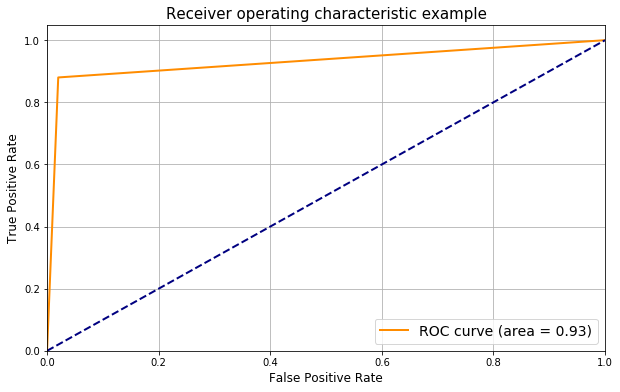

In [31]:
plot_roc(y_true_2, y_score_2)

In [32]:
def positive_negative_measurement(y_true, y_score):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score)):
        if y_true[i] == y_score[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score[i] == 1) and (y_true[i] != y_score[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score[i] == 0) and (y_true[i] != y_score[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [33]:
TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = positive_negative_measurement(y_true_2, y_score_2)
postives_negatives = [[TRUE_POSITIVE, FALSE_POSITIVE], 
                      [FALSE_NEGATIVE, TRUE_NEGATIVE]]

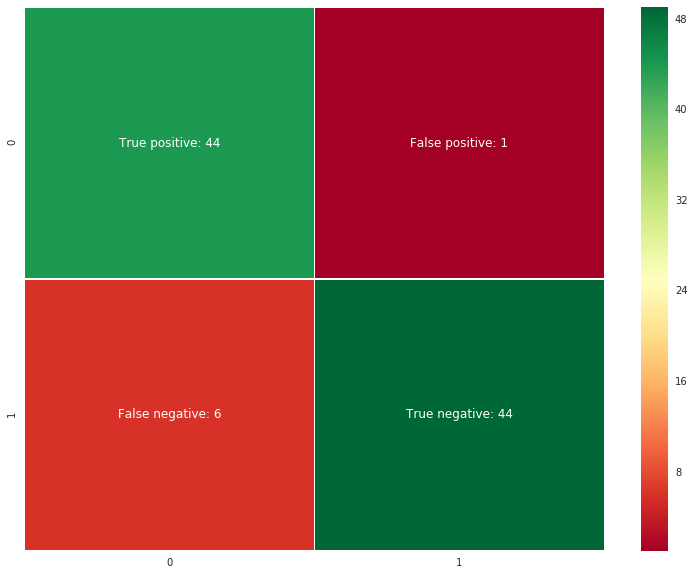

In [34]:
import seaborn as sns
sns.set()
labels =  np.array([['True positive: ' + str(TRUE_POSITIVE),
                     'False positive: ' + str(FALSE_POSITIVE)],
                    ['False negative: ' + str(FALSE_NEGATIVE),
                     'True negative: ' + str(TRUE_POSITIVE)]])
plt.figure(figsize = (13, 10))
sns.heatmap(postives_negatives, annot = labels, linewidths = 0.1, fmt="", cmap = 'RdYlGn')

In [35]:
# Sensitivity | Recall | hit rate | true positive rate (TPR)
sensitivity = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
print("Sensitivity: ", sensitivity)

Sensitivity:  0.88


In [36]:
# Specificity | selectivity | true negative rate (TNR)
specifity = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
print("Specifity: ", specifity)

Specifity:  0.8909090909090909


In [37]:
# Precision | positive predictive value (PPV)
predcision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
print("Precision: ", predcision)

Precision:  0.9777777777777777


In [38]:
# Negative predictive value (NPV)
npv = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
print("Negative predictive value: ", npv)

Negative predictive value:  0.8909090909090909


In [39]:
# Accuracy 
accuracy = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + TRUE_NEGATIVE + FALSE_NEGATIVE)
print("Accuracy: ", accuracy)

Accuracy:  0.93


### 4.2. Evaluating Inception

In [21]:
# Compute test set predictions
NUMBER_TEST_SAMPLES = 100

y_true = valid_targets[:NUMBER_TEST_SAMPLES]
y_score = []
for index in range(NUMBER_TEST_SAMPLES): #compute one at a time due to memory constraints
    probs = predict(img_path = valid_files[index])
    print("Real values {}...".format(index+1) + "Melanoma : ", valid_targets[index][0], " | Other : ", valid_targets[index][1])
    print("---------------------------------------------------------------------------")
    y_score.append(probs)
    
correct = np.array(y_true) == np.array(y_score)

Prediction... Melanoma :  0.9999  | Other :  0.000100462
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.999998  | Other :  1.79798e-06
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.159793  | Other :  0.840207
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.999999  | Other :  1.27819e-06
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.187715  | Other :  0.812285
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  1.0  | Other :  5.07611e-08
Real values...Melanoma :  1.0  | Other :  0.0
---

Prediction... Melanoma :  0.0347534  | Other :  0.965247
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.111374  | Other :  0.888626
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.0205129  | Other :  0.979487
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.238845  | Other :  0.761155
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.999997  | Other :  3.37599e-06
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  1.0  | Other :  1.19397e-08
Real values...Melanoma :  1.0  | Other :  0.0
-----

Prediction... Melanoma :  0.999999  | Other :  9.70454e-07
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.999993  | Other :  7.24275e-06
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.000367583  | Other :  0.999632
Real values...Melanoma :  0.0  | Other :  1.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.999979  | Other :  2.05108e-05
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.999996  | Other :  4.35911e-06
Real values...Melanoma :  1.0  | Other :  0.0
---------------------------------------------------------------------------
Prediction... Melanoma :  0.0184551  | Other :  0.981545
Real values...Melanoma :  0.0  | Other

In [22]:
print("Accuracy = %2.2f%%" % (np.mean(correct)*100))

Accuracy = 92.00%


In [24]:
# Re-ordering the actual y (for ROC)
y_true_2 = []
for i in range(len(y_true)):
    y_true_2.append(y_true[i][0])
    
# Re-ordering the predicte y (for ROC)
y_score_2 = []
for i in range(len(y_score)):
    y_score_2.append(y_score[i][0])

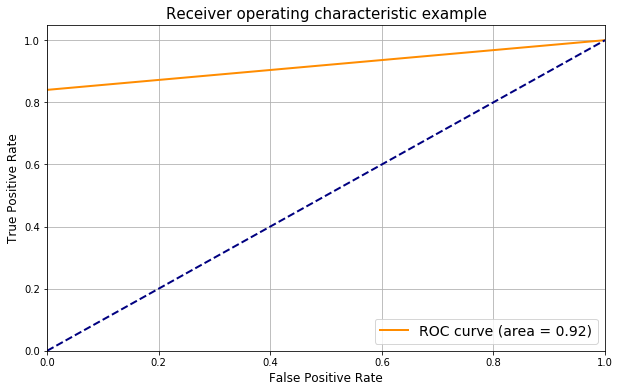

In [25]:
plot_roc(y_true_2, y_score_2)

In [36]:
def positive_negative_measurement(y_true, y_score):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score)):
        if y_true[i] == y_score[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score[i] == 1) and (y_true[i] != y_score[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score[i] == 0) and (y_true[i] != y_score[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [27]:
TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = positive_negative_measurement(y_true_2, y_score_2)
postives_negatives = [[TRUE_POSITIVE, FALSE_POSITIVE], 
                      [FALSE_NEGATIVE, TRUE_NEGATIVE]]

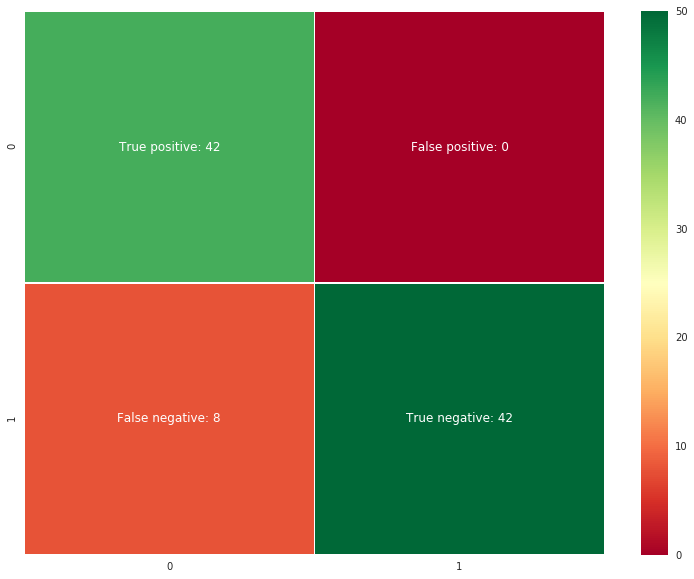

In [28]:
import seaborn as sns
sns.set()
labels =  np.array([['True positive: ' + str(TRUE_POSITIVE),
                     'False positive: ' + str(FALSE_POSITIVE)],
                    ['False negative: ' + str(FALSE_NEGATIVE),
                     'True negative: ' + str(TRUE_POSITIVE)]])
plt.figure(figsize = (13, 10))
sns.heatmap(postives_negatives, annot = labels, linewidths = 0.1, fmt="", cmap = 'RdYlGn')

In [ ]:
# Sensitivity | Recall | hit rate | true positive rate (TPR)
sensitivity = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
print("Sensitivity: ", sensitivity)

# Specificity | selectivity | true negative rate (TNR)
specifity = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
print("Specifity: ", specifity)

# Precision | positive predictive value (PPV)
predcision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
print("Precision: ", predcision)

# Negative predictive value (NPV)
npv = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
print("Negative predictive value: ", npv)

# Accuracy 
accuracy = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + TRUE_NEGATIVE + FALSE_NEGATIVE)
print("Accuracy: ", accuracy)

## 5. Ensembling the models

In [23]:
from keras.layers import Input

In [24]:
# Single input for multiple models
model_input = Input(shape=(512, 512, 3))

In [25]:
def mobilenet_architecture():
    """
    Pre-build architecture of mobilenet for our dataset.
    """
    # Imprting the model
    from keras.applications.mobilenet import MobileNet

    # Pre-build model
    base_model = MobileNet(include_top = False, weights = None, input_tensor = model_input)

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 2, activation = 'softmax')(x)

    # Creating the whole model
    mobilenet_model = Model(base_model.input, output)
    
    # Getting the summary of architecture
    #mobilenet_model.summary()
    
    # Compiling the model
    mobilenet_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])

    return mobilenet_model

In [26]:
# Model 1
mobilenet_model = mobilenet_architecture()
mobilenet_model.load_weights("./Saved models/weights.best.mobilenet_epoch_2.hdf5")

In [27]:
def inception_architecture():
    """
    Pre-build architecture of inception for our dataset.
    """
    # Imprting the model 
    from keras.applications.inception_v3 import InceptionV3

    # Pre-build model
    base_model = InceptionV3(include_top = False, weights = None, input_tensor = model_input)

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 2, activation = 'softmax')(x)

    # Creating the whole model
    inception_model = Model(base_model.input, output)
    
    # Summary of the model
    #inception_model.summary()
    
    # Compiling the model
    inception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                            loss = 'categorical_crossentropy', 
                            metrics = ['accuracy'])
    
    return inception_model

In [28]:
# Model 2
inception_model = inception_architecture()
inception_model.load_weights("./Saved models/weights.best.inception.hdf5")

In [29]:
def xception_architecture():
    """
    Pre-build architecture of inception for our dataset.
    """
    # Imprting the model
    from keras.applications.xception import Xception

    # Pre-build model
    base_model = Xception(include_top = False, weights = None, input_tensor = model_input)

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 2, activation = 'softmax')(x)

    # Creating the whole model
    xception_model = Model(base_model.input, output)

    # Summary of the model
    #xception_model.summary()
    
    # Compiling the model
    xception_model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                           loss = 'categorical_crossentropy', 
                           metrics = ['accuracy'])

    return xception_model

In [30]:
# Model 3
xception_model = xception_architecture()
xception_model.load_weights("./Saved models/weights.best.xception.hdf5")

In [31]:
# Appending all models
models = [mobilenet_model, inception_model, xception_model]

In [32]:
def ensemble(models, model_input):
    
    outputs = [model.outputs[0] for model in models]
    
    y = keras.layers.Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model

In [33]:
# Getting ensemble model
ensemble_model = ensemble(models, model_input)

In [68]:
image_to_predict = path_to_tensor("./../Skin cancer/Dataset/melanoma/ISIC_001126890angle-flipped.jpg").astype('float32')/255.
ensemble_model.predict(image_to_predict)

array([[  9.99203920e-01,   7.96056644e-04]], dtype=float32)

## 5. 2. Evaluating ensemble model

In [44]:
# Compute test set predictions
NUMBER_TEST_SAMPLES = 200

y_true = valid_targets[:NUMBER_TEST_SAMPLES]
y_score = []
for index in range(NUMBER_TEST_SAMPLES): #compute one at a time due to memory constraints
    image_to_predict = path_to_tensor(valid_files[index]).astype("float32")/255.
    probs = ensemble_model.predict(image_to_predict)
    if np.argmax(probs) == 0:
        y_score.append([1., 0.])
    elif np.argmax(probs) == 1:
        y_score.append([0., 1.])
    print("Predicted value {}... ".format(index+1) + " Melanoma : ", probs[0][0],  " | Other : ", probs[0][1])
    print("Real values {}...".format(index+1) + "      Melanoma : ", valid_targets[index][0], "      | Other : ", valid_targets[index][1])
    print("---------------------------------------------------------------------------")
    
    
correct = np.array(y_true) == np.array(y_score)

Predicted value 1...  Melanoma :  0.960816  | Other :  0.0391842
Real values 1...      Melanoma :  1.0       | Other :  0.0
---------------------------------------------------------------------------
Predicted value 2...  Melanoma :  0.999931  | Other :  6.93357e-05
Real values 2...      Melanoma :  1.0       | Other :  0.0
---------------------------------------------------------------------------
Predicted value 3...  Melanoma :  0.335943  | Other :  0.664057
Real values 3...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 4...  Melanoma :  0.718694  | Other :  0.281306
Real values 4...      Melanoma :  1.0       | Other :  0.0
---------------------------------------------------------------------------
Predicted value 5...  Melanoma :  0.246371  | Other :  0.753629
Real values 5...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
P

Predicted value 42...  Melanoma :  0.45868  | Other :  0.54132
Real values 42...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 43...  Melanoma :  0.13713  | Other :  0.86287
Real values 43...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 44...  Melanoma :  0.999937  | Other :  6.33611e-05
Real values 44...      Melanoma :  1.0       | Other :  0.0
---------------------------------------------------------------------------
Predicted value 45...  Melanoma :  0.0934377  | Other :  0.906562
Real values 45...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 46...  Melanoma :  0.999979  | Other :  2.11086e-05
Real values 46...      Melanoma :  1.0       | Other :  0.0
--------------------------------------------------------------------

Predicted value 83...  Melanoma :  0.148754  | Other :  0.851247
Real values 83...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 84...  Melanoma :  0.00695964  | Other :  0.99304
Real values 84...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 85...  Melanoma :  0.0989052  | Other :  0.901095
Real values 85...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 86...  Melanoma :  0.00138937  | Other :  0.998611
Real values 86...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 87...  Melanoma :  0.999993  | Other :  7.11108e-06
Real values 87...      Melanoma :  1.0       | Other :  0.0
----------------------------------------------------------------

Predicted value 124...  Melanoma :  0.265627  | Other :  0.734373
Real values 124...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 125...  Melanoma :  0.897038  | Other :  0.102962
Real values 125...      Melanoma :  1.0       | Other :  0.0
---------------------------------------------------------------------------
Predicted value 126...  Melanoma :  0.999995  | Other :  4.51865e-06
Real values 126...      Melanoma :  1.0       | Other :  0.0
---------------------------------------------------------------------------
Predicted value 127...  Melanoma :  0.120275  | Other :  0.879725
Real values 127...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 128...  Melanoma :  0.019174  | Other :  0.980826
Real values 128...      Melanoma :  0.0       | Other :  1.0
----------------------------------------------------------

Predicted value 165...  Melanoma :  0.00140327  | Other :  0.998597
Real values 165...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 166...  Melanoma :  0.989111  | Other :  0.0108894
Real values 166...      Melanoma :  1.0       | Other :  0.0
---------------------------------------------------------------------------
Predicted value 167...  Melanoma :  0.999809  | Other :  0.000190595
Real values 167...      Melanoma :  1.0       | Other :  0.0
---------------------------------------------------------------------------
Predicted value 168...  Melanoma :  0.427897  | Other :  0.572103
Real values 168...      Melanoma :  0.0       | Other :  1.0
---------------------------------------------------------------------------
Predicted value 169...  Melanoma :  0.278637  | Other :  0.721363
Real values 169...      Melanoma :  0.0       | Other :  1.0
-------------------------------------------------------

In [45]:
print("Accuracy = %2.2f%%" % (np.mean(correct)*100))

Accuracy = 95.00%


In [46]:
# Re-ordering the actual y (for ROC)
y_true_2 = []
for i in range(len(y_true)):
    y_true_2.append(y_true[i][0])
    
# Re-ordering the predicte y (for ROC)
y_score_2 = []
for i in range(len(y_score)):
    y_score_2.append(y_score[i][0])

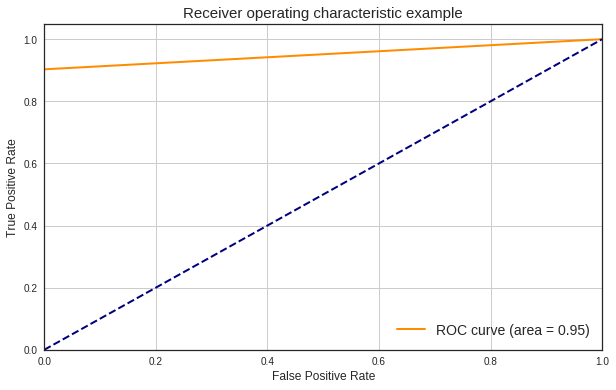

In [69]:
plot_roc(y_true_2, y_score_2)

In [48]:
def positive_negative_measurement(y_true, y_score):
    # Initialization
    TRUE_POSITIVE = 0
    FALSE_POSITIVE = 0
    TRUE_NEGATIVE = 0
    FALSE_NEGATIVE = 0
    
    # Calculating the model
    for i in range(len(y_score)):
        if y_true[i] == y_score[i] == 1:
            TRUE_POSITIVE += 1
        if (y_score[i] == 1) and (y_true[i] != y_score[i]):
            FALSE_POSITIVE += 1
        if y_true[i] == y_score[i] == 0:
            TRUE_NEGATIVE += 1
        if (y_score[i] == 0) and (y_true[i] != y_score[i]):
            FALSE_NEGATIVE += 1

    return(TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE)

In [49]:
TRUE_POSITIVE, FALSE_POSITIVE, TRUE_NEGATIVE, FALSE_NEGATIVE = positive_negative_measurement(y_true_2, y_score_2)
postives_negatives = [[TRUE_POSITIVE, FALSE_POSITIVE], 
                      [FALSE_NEGATIVE, TRUE_NEGATIVE]]

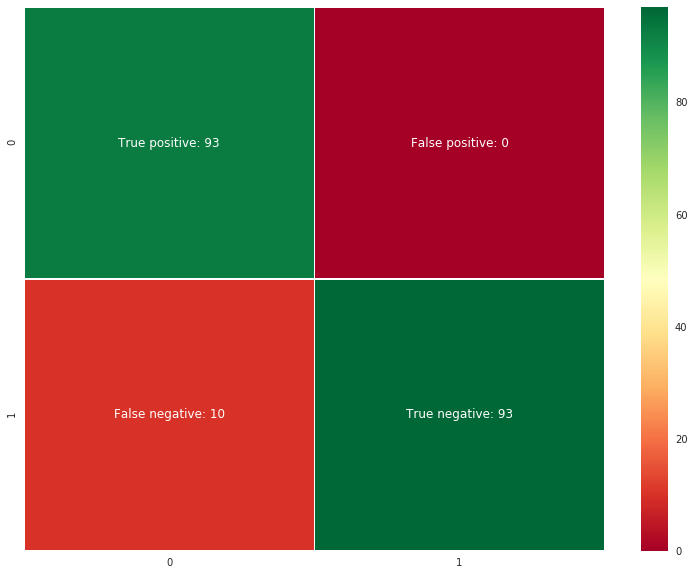

In [50]:
import seaborn as sns
sns.set()
labels =  np.array([['True positive: ' + str(TRUE_POSITIVE),
                     'False positive: ' + str(FALSE_POSITIVE)],
                    ['False negative: ' + str(FALSE_NEGATIVE),
                     'True negative: ' + str(TRUE_POSITIVE)]])
plt.figure(figsize = (13, 10))
sns.heatmap(postives_negatives, annot = labels, linewidths = 0.1, fmt="", cmap = 'RdYlGn')

In [51]:
# Sensitivity | Recall | hit rate | true positive rate (TPR)
sensitivity = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_NEGATIVE)
print("Sensitivity: ", sensitivity)

# Specificity | selectivity | true negative rate (TNR)
specifity = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
print("Specifity: ", specifity)

# Precision | positive predictive value (PPV)
predcision = TRUE_POSITIVE / (TRUE_POSITIVE + FALSE_POSITIVE)
print("Precision: ", predcision)

# Negative predictive value (NPV)
npv = TRUE_NEGATIVE / (TRUE_NEGATIVE + FALSE_NEGATIVE)
print("Negative predictive value: ", npv)

# Accuracy 
accuracy = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + TRUE_NEGATIVE + FALSE_NEGATIVE)
print("Accuracy: ", accuracy)

Sensitivity:  0.9029126213592233
Specifity:  0.9065420560747663
Precision:  1.0
Negative predictive value:  0.9065420560747663
Accuracy:  0.95


## 6. Localization

In [52]:
# Importing the libraries
from keras.applications.mobilenet import preprocess_input
import scipy
import cv2

In [53]:
path_to_model_weight = "./Saved models/weights.best.mobilenet.hdf5"

In [54]:
img_path = "./Dataset/Image dataset/melanoma/ISIC_0026167_180_angle.jpg"

In [55]:
def getting_two_layer_weights(path_model_weight = path_to_model_weight):
    # The model

    # Imprting the model
    from keras.applications.mobilenet import MobileNet

    # Pre-build model
    base_model = MobileNet(include_top = False, weights = None, input_shape = (512, 512, 3))

    # Adding output layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(units = 2, activation = 'softmax')(x)

    # Creating the whole model
    model = Model(base_model.input, output)
    #model.summary()

    # Compiling the model
    model.compile(optimizer = keras.optimizers.Adam(lr = 0.001), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
    # loading the weights
    model.load_weights(path_model_weight)
    
    # Getting the AMP layer weight
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    
    # Extracting the wanted output
    mobilenet_model = Model(inputs = model.input, outputs = (model.layers[-3].output, model.layers[-1].output))
    
    return mobilenet_model, all_amp_layer_weights

In [56]:
mobilenet_model, all_amp_layer_weights = getting_two_layer_weights(path_to_model_weight)

In [57]:
def mobilenet_CAM(img_path, model, all_amp_layer_weights):
    # Getting filtered images from last convolutional layer + model prediction output
    last_conv_output, predictions = model.predict(path_to_tensor(img_path)) # last_conv_output.shape = (1, 16, 16, 1024)
    
    # Converting the dimension of last convolutional layer to 16 x 16 x 1024     
    last_conv_output = np.squeeze(last_conv_output)
    
    # Model's prediction
    predicted_class = np.argmax(predictions)
    
    # Bilinear upsampling (resize each image to size of original image)
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order = 1)  # dim from (16, 16, 1024) to (512, 512, 1024)
    
    # Getting the AMP layer weights
    amp_layer_weights = all_amp_layer_weights[:, predicted_class] # dim: (1024,)    
    
    # CAM for object class that is predicted to be in the image
    final_output = np.dot(mat_for_mult, amp_layer_weights) # dim: 512 x 512

    # Return class activation map (CAM)
    return final_output, predicted_class

In [58]:
final_output, predicted_class = mobilenet_CAM(img_path, mobilenet_model, all_amp_layer_weights)

In [59]:
def plot_CAM(img_path, ax, model, all_amp_layer_weights):
    # Loading the image / resizing to 512x512 / Converting BGR to RGB
    #im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (512, 512))
    im = path_to_tensor(img_path).astype("float32")/255.
    
    # Plotting the image
    ax.imshow(im.squeeze(), vmin=0, vmax=255)
    
    # Getting the class activation map
    CAM, pred = mobilenet_CAM(img_path, model, all_amp_layer_weights)
    
    CAM = (CAM - CAM.min()) / (CAM.max() - CAM.min())
    
    # Plotting the class activation map
    ax.imshow(CAM, cmap = "jet", alpha = 0.5, interpolation='nearest', vmin=0, vmax=1)

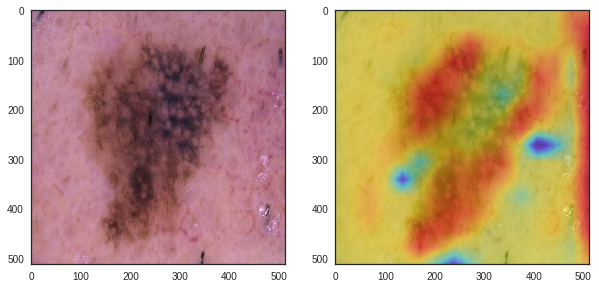

In [71]:
# Visualizing images with and without localization
# Canvas
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 10))
# Image without localization
ax[0].imshow((path_to_tensor(img_path).astype('float32')/255).squeeze())
# Image with localization
CAM = plot_CAM(img_path, ax[1], mobilenet_model, all_amp_layer_weights)
plt.show()

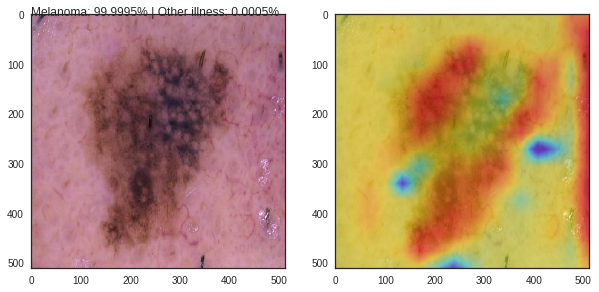

In [100]:
# Getting the iamge tensor
image_to_predict = path_to_tensor(img_path).astype('float32')/255

# Predicting the image
prediction = ensemble_model.predict(image_to_predict)
prediction_final = "Melanoma: " + str(np.round(pred[0][0]*100, decimals = 4)) + "%" + \
                   " | Other illness: " + str(np.round(pred[0][1]*100, decimals = 4)) + "%"

# Canvas initialization
fig = plt.figure(figsize = (10, 10))

# First image
ax = fig.add_subplot(121)
ax.imshow(image_to_predict.squeeze())
ax.text(0.3, 1.6, prediction_final)

# Second image
ax = fig.add_subplot(122)
CAM = plot_CAM(img_path, ax, mobilenet_model, all_amp_layer_weights)

plt.show()